## 1. Import Required Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from xgboost import XGBClassifier

## 2. Load and Clean the Dataset

We will load the **Adult Income** dataset, handle missing values, encode categorical features, and prepare it for training.


In [2]:
# Define column names
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num',
           'marital-status', 'occupation', 'relationship', 'race', 'sex',
           'capital-gain', 'capital-loss', 'hours-per-week', 'native-country', 'income']

# Load the dataset
df = pd.read_csv('/content/adult_moins.csv', header=None, names=columns,
                 na_values=' ?', skipinitialspace=True)

# Show missing values before cleaning
print("Missing values before cleaning:")
print(df.isnull().sum())

# Drop rows with missing values
df.dropna(inplace=True)

# Encode target column: '>50K' = 1, '<=50K' = 0
df['income'] = df['income'].apply(lambda x: 1 if x == '>50K' else 0)

# One-hot encode categorical features
categorical_cols = df.select_dtypes(include=['object']).columns
df_encoded = pd.get_dummies(df, columns=categorical_cols, drop_first=True)


Missing values before cleaning:
age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64


## 3. Feature Scaling and Train/Test Split

We will separate features and labels, scale the features, and split the dataset into training and test sets.


In [3]:
# Separate input features and target
X = df_encoded.drop('income', axis=1)
y = df_encoded['income']

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)


## 4. Train XGBoost Classifier (All Features)

We'll train a classifier using all original features and evaluate its performance using accuracy and classification report.


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [19:10:53] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



 Classification Report:

              precision    recall  f1-score   support

           0       0.84      0.93      0.88        41
           1       0.40      0.22      0.29         9

    accuracy                           0.80        50
   macro avg       0.62      0.57      0.58        50
weighted avg       0.76      0.80      0.78        50


 Accuracy Score: 0.8


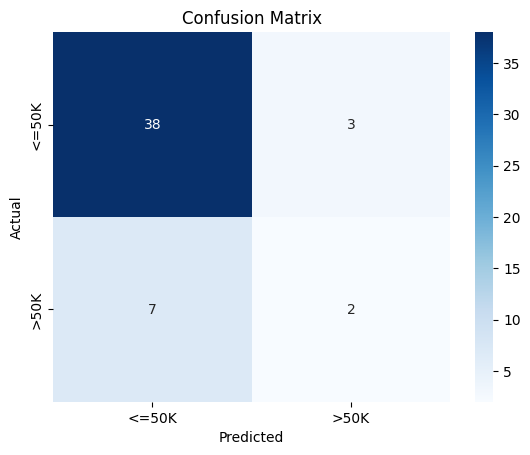

In [4]:
# Train XGBoost model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_model.fit(X_train, y_train)

# Make predictions
y_pred = xgb_model.predict(X_test)

# Evaluation
print("\n Classification Report:\n")
print(classification_report(y_test, y_pred))
print("\n Accuracy Score:", accuracy_score(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['<=50K','>50K'], yticklabels=['<=50K','>50K'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


## 5. Dimensionality Reduction using PCA

We reduce the data to 2 principal components for visualization purposes.


In [5]:
# Reduce to 2 dimensions with PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Train/test split for PCA-reduced data
X_pca_train, X_pca_test = train_test_split(X_pca, test_size=0.2, random_state=42)


## 6. Train XGBoost Classifier on 2D Data

Train XGBoost again, but this time using only the 2D PCA-reduced data.


In [6]:
# Train XGBoost on PCA-reduced features
xgb_2d = XGBClassifier(eval_metric='logloss', random_state=42)
xgb_2d.fit(X_pca_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, ...)

## 7. Visualize Decision Boundary

We visualize the PCA-reduced test data and overlay the XGBoost decision boundary.


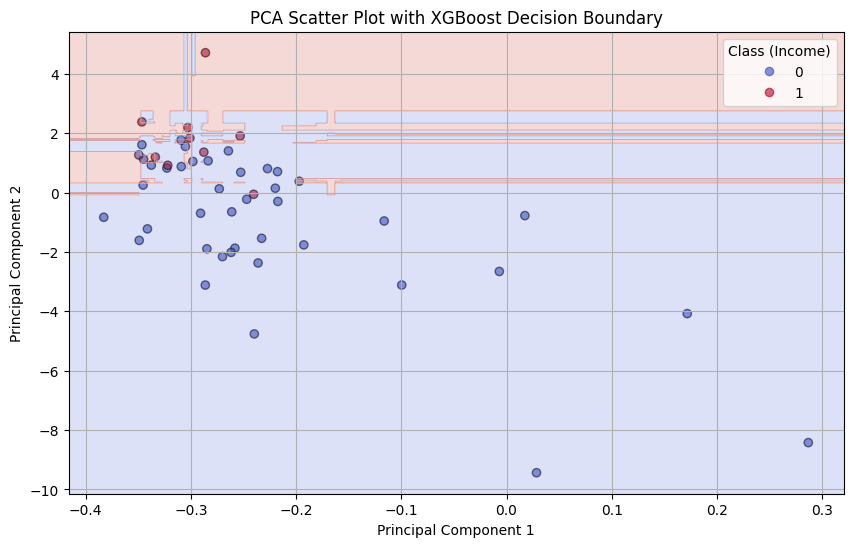

In [7]:
# Plot PCA points and decision boundary
plt.figure(figsize=(10,6))

# Scatter plot
scatter = plt.scatter(X_pca_test[:, 0], X_pca_test[:, 1],
                      c=y_test, cmap='coolwarm', alpha=0.6, edgecolors='k')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Scatter Plot with XGBoost Decision Boundary')
plt.legend(*scatter.legend_elements(), title="Class (Income)")
plt.grid(True)

# Create meshgrid for contour plot
ax = plt.gca()
xlim = ax.get_xlim()
ylim = ax.get_ylim()
xx, yy = np.meshgrid(np.linspace(xlim[0], xlim[1], 500),
                     np.linspace(ylim[0], ylim[1], 500))
xy = np.vstack([xx.ravel(), yy.ravel()]).T

# Predict on grid
Z = xgb_2d.predict(xy).reshape(xx.shape)

# Decision boundary
plt.contourf(xx, yy, Z, alpha=0.2, cmap='coolwarm')
plt.show()
